In [20]:
!pip install ordpy

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string
import glob
import warnings
import math
from scipy.fft import fft, ifft
from scipy.io import savemat
import matplotlib.colors as mcolors
from ordpy import complexity_entropy

def jensen_shannon(PDF):
    N = len(PDF)
    PDF_eq = np.ones(N) / N
    PDF2 = (PDF + PDF_eq) / 2
    jensen_shannon = (np.sum(-PDF2[PDF2 > 0] * np.log(PDF2[PDF2 > 0]))
                      - np.sum(-PDF[PDF > 0] * np.log(PDF[PDF > 0])) / 2
                      - np.sum(-PDF_eq[PDF_eq > 0] * np.log(PDF_eq[PDF_eq > 0])) / 2)
    return jensen_shannon



def des_jensen_shannon(PDF):
    N = len(PDF)
    Q0 = -2 * ((N + 1) / N * np.log(1 + N) - 2 * np.log(2 * N) + np.log(N)) ** -1
    return Q0 * jensen_shannon(PDF)

def Complejidad_MPR(PDF):
    return des_jensen_shannon(PDF) * Entropia_de_Shannon(PDF)

def Entropia_de_Shannon(PDF):
    N = len(PDF)
    PDF_eq = np.ones(N) / N
    entropia_maxima = np.sum(-(PDF_eq[PDF_eq > 0] * np.log(PDF_eq[PDF_eq > 0])))
    return np.sum(-(PDF[PDF > 0] * np.log(PDF[PDF > 0]))) / entropia_maxima

def Complejidad_entropia_JS(probabilities):
    h = Entropia_de_Shannon(probabilities)  # Entropía de Shannon
    complexity = Complejidad_MPR(probabilities) # Complejidad estadística
    return np.asarray([h, complexity]).T

def calcular_probabilidad(time_series, bins=100):
    """
    Calcula la función de probabilidad (normalizada) de una serie temporal.

    Parameters:
    time_series (array-like): Serie temporal de la cual se quiere calcular la función de probabilidad.
    bins (int): Número de bines a utilizar para el histograma.

    Returns:
    np.array: Función de probabilidad normalizada.

    Ejemplo de uso:
    ---------------
    time_series = np.random.randn(1000)  # Generar una serie temporal aleatoria
    probabilidades = calcular_probabilidad(time_series, bins=100)
    print(probabilidades)
    """
    hist, _ = np.histogram(time_series, bins=bins)
    probabilities = hist / np.sum(hist)
    return probabilities

def minimum_complexityJS_entropy(bin=10, m=100):
    N = bin
    hlist_, clist_ = np.zeros((N-1, m)), np.zeros((N-1, m))
    for i in range(N-1):
        p             = np.zeros(shape=N)
        uniform_dist  = np.full(N, 1/N)
        prob_params   = np.linspace(0, 1/N, num=m)

        for k in range(len(prob_params)):
            p[0] = prob_params[k]
            for j in range(1,N-i):
                p[j] = (1-prob_params[k])/(N-i-1)
            h = Entropia_de_Shannon(p)
            p_plus_u_over_2      = (uniform_dist + p)/2
            s_of_p_plus_u_over_2 = -np.sum(p_plus_u_over_2*np.log(p_plus_u_over_2))

            p_non_zero    = p[p!=0]
            s_of_p_over_2 = -np.sum(p_non_zero*np.log(p_non_zero))/2
            s_of_u_over_2 = np.log(N)/2.

            js_div_max = -0.5*(((N+1)/N)*np.log(N+1) + np.log(N) - 2*np.log(2*N))
            js_div     = s_of_p_plus_u_over_2 - s_of_p_over_2 - s_of_u_over_2
            hlist_[i, k] = h
            clist_[i, k] = h*js_div/js_div_max

    #flatenning the arrays and ordering the pairs of values.
    hlist_ = hlist_.flatten()
    clist_ = clist_.flatten()
    args   = np.argsort(hlist_)

    return np.asarray((hlist_[args], clist_[args])).T


def maximun_complexityJS_entropy(bin=3, m=100):

    m        += 1
    N            = bin
    prob_params  = np.linspace(1/N, 1, num=m-1)
    uniform_dist = np.full(N, 1/N)
    hc_ = []
    for i in range(m-1):
        probabilities    = np.full(shape=N, fill_value=(1-prob_params[i])/(N-1))
        probabilities[0] = prob_params[i]
        h = Entropia_de_Shannon(probabilities)
        p_plus_u_over_2      = (uniform_dist + probabilities)/2
        s_of_p_plus_u_over_2 = -np.sum(p_plus_u_over_2*np.log(p_plus_u_over_2))

        probabilities = probabilities[probabilities!=0]
        s_of_p_over_2 = -np.sum(probabilities*np.log(probabilities))/2
        s_of_u_over_2 = np.log(N)/2.

        js_div_max = -0.5*(((N+1)/N)*np.log(N+1) + np.log(N) - 2*np.log(2*N))
        js_div     = s_of_p_plus_u_over_2 - s_of_p_over_2 - s_of_u_over_2
        hc_.append([h, h*js_div/js_div_max])

    return np.flip(hc_, axis=0)


import math
from ordpy import ordinal_distribution

def probabilidad_BP(series_temporal, dx, taux=1):
    """
    Calcula las probabilidades de los patrones ordinales en una serie temporal.

    Parámetros:
    series_temporal (list or np.array): La serie temporal de entrada.
    dx (int): Dimensión de embebido (por defecto 3).
    taux (int): Retardo de embebido (por defecto 1).

    Retorna:
    np.array: Las probabilidades de los patrones ordinales.
    """
    # Calcular la distribución de probabilidad de los patrones ordinales
    _, probabilidades = ordinal_distribution(series_temporal, dx, dy=1, taux=1, tauy=1, return_missing=True, tie_precision=None)
    # Devolver solo las probabilidades
    return probabilidades

In [22]:
# Definición del mapa de colores personalizado
num_colors = 5
control_points = [0, 0.25, 0.5, 0.75, 1]
# colorss should have shape (num_colors, 3) to define RGB for each color
colorss = [
    [157/255, 1/255, 66/255],  # Color 1: #9d0142
    [246/255, 110/255, 69/255],  # Color 2: #f66e45
    [249/255, 231/255, 159/255],  # Color 3: #ffffbb
    [101/255, 192/255, 174/255],  # Color 4: #65c0ae
    [94/255, 79/255, 159/255]   # Color 5: #5e4f9f
]

# ... (rest of the code remains the same)


<ipython-input-23-5ca8b2526ba2>:136: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(henon_map_averaged_RE, henon_map_averaged_RC, 'o', marker='D', markersize=10, color='tab:purple', label='Mapa de Hénon')
<ipython-input-23-5ca8b2526ba2>:138: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_noise_E, k_noise_C, 'o--', marker='.',  markersize=13,color='tab:cyan', label='K-noise')
<ipython-input-23-5ca8b2526ba2>:139: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(schus_E, schus_C, 'o', marker='^', markersize=11, color='deeppink', label='Mapa de Schuster')
<ipython-input-23-5ca8b2526ba2>:140: UserWarning: marker is redundantly

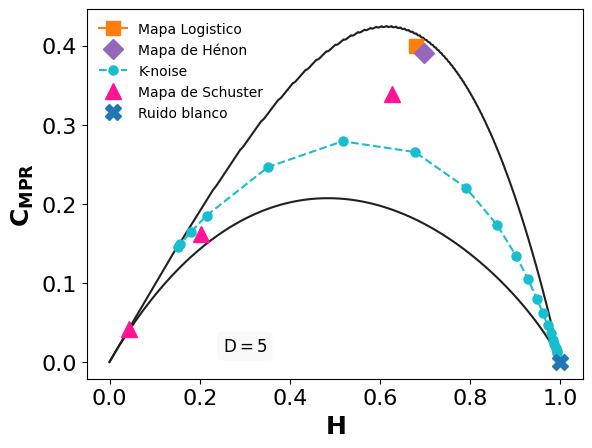

In [23]:
# Cotas
D = 5
m = 100 #puntos de las cotas
hc_max_curve = maximun_complexityJS_entropy(bin=math.factorial(D),m=m).T
hc_min_curve = minimum_complexityJS_entropy(bin=math.factorial(D),m=m).T
hmin, cmin = hc_min_curve
hmax, cmax = hc_max_curve


# Parámetros del mapa logístico
r = 4
# Inicialización
x = np.zeros(100000)
x[0] = 0.1

# Generación de la serie utilizando el mapa logístico
for t in range(1, len(x)):
    x[t] = r * x[t-1] * (1 - x[t-1])

# Calcula mapa_RE
mapa_RE,mapa_RC =  Complejidad_entropia_JS(probabilidad_BP(x, D))
#mapa_RE,mapa_RC =  renyi_complexity_entropy(x,1,D, 1)
# Function to generate white noise series
def generate_white_noise(length):
    return np.random.randn(length)

# Function to generate regular oscillations
def generate_regular_oscillations(length, frequency, amplitude):
    t = np.linspace(0, 1, length)
    return amplitude * np.sin(2 * np.pi * frequency * t)

# Function to generate Henon map series and average its components
def generate_henon_map_averaged(length, a, b):
    x = np.zeros(length)
    y = np.zeros(length)

    for t in range(1, length):
        x[t] = 1 - a * x[t - 1] ** 2 + y[t - 1]
        y[t] = b * x[t - 1]

    # Average the two components to create a single time series
    averaged_series = (x + y) / 2.0

    return averaged_series

# Número de filas en la matriz
num_filas = 20
alpha_max = 5
paso = alpha_max / num_filas
num_valores = int(alpha_max / paso) + 1  # Número de valores en el vector

# Longitud de cada serie temporal
longitud = 100000


# Opción 1: Distribución logarítmica
alpha_range = np.logspace(0, np.log10(alpha_max), num_valores)

# Matriz para almacenar las series temporales
matriz = np.zeros((num_filas, longitud))
entropy = np.zeros(num_filas)
complexity = np.zeros(num_filas)

k_noise_E = np.zeros(num_filas)
k_noise_C = np.zeros(num_filas)
# Iterar a través de cada fila y generar una serie temporal
for i in range(num_filas):
    # Seleccionar un valor aleatorio de alpha en el rango especificado
    alpha = alpha_range[i]

    # Generar una serie temporal de ruido de color 1/|f|^(alpha)
    serie_temporal = np.real(ifft(fft(np.random.randn(longitud)) * (1 / np.arange(1, longitud + 1) ** (alpha / 2))))

    # Agregar la serie temporal a la matriz
    matriz[i, :] = serie_temporal
    e,c=Complejidad_entropia_JS(probabilidad_BP(serie_temporal,D))
    k_noise_E[i] = e
    k_noise_C[i] = c


def schuster_map(x0, z, num_steps):
    """
    Calcula una serie temporal usando el mapa de Schuster.

    Args:
        x0 (float): Valor inicial de x.
        z (float): Parámetro z (debe ser 2, 2.5 o 3).
        num_steps (int): Número de pasos de tiempo para generar la serie temporal.

    Returns:
        List[float]: Lista de valores de la serie temporal generada.
    """
    x_values = []
    x = x0

    for _ in range(num_steps):
        x = (x + x ** z) % 1
        x_values.append(x)

    return x_values

# Generate schuster series
x0 = 0.1  # Valor inicial de x
z_values = [3/2,2,5/2]  # Valores de z
indice=0
schus_E = np.zeros(3)  # Inicializa un ndarray con tres elementos para almacenar valores de e
schus_C = np.zeros(3)  # Inicializa un ndarray con tres elementos para almacenar valores de c

for i in [0,1,2]:
    #print(i)
    serie_temporal = schuster_map(x0, z_values[i], longitud)
    e,c=Complejidad_entropia_JS(probabilidad_BP(serie_temporal,D))
    schus_E[i] = e
    schus_C[i] = c

# Generate white noise series
white_noise = generate_white_noise(100000)

# Generate regular oscillations
oscillations = generate_regular_oscillations(100000, frequency=2, amplitude=0.5)

# Generate Henon map series and average its components
henon_map_averaged = generate_henon_map_averaged(100000, a=1.4, b=0.3)

# Calculate Renyi Complexity and Entropy for the new series
white_noise_RE, white_noise_RC = Complejidad_entropia_JS(probabilidad_BP(white_noise,D))
oscillations_RE, oscillations_RC = Complejidad_entropia_JS(probabilidad_BP(oscillations,D))
henon_map_averaged_RE, henon_map_averaged_RC = Complejidad_entropia_JS(probabilidad_BP(henon_map_averaged,dx=D))

# Las curvas de hmin y cmin se grafican sin líneas punteadas
plt.plot(mapa_RE, mapa_RC, marker='s', markersize=10, color='tab:orange', label='Mapa Logistico')

# Utiliza líneas punteadas para conectar los puntos de las otras curvas

#plt.plot(oscillations_RE, oscillations_RC, '--o', marker='s', markersize=5, markerfacecolor='b', color='b', label='Regular Oscillations')
plt.plot(henon_map_averaged_RE, henon_map_averaged_RC, 'o', marker='D', markersize=10, color='tab:purple', label='Mapa de Hénon')

plt.plot(k_noise_E, k_noise_C, 'o--', marker='.',  markersize=13,color='tab:cyan', label='K-noise')
plt.plot(schus_E, schus_C, 'o', marker='^', markersize=11, color='deeppink', label='Mapa de Schuster')
plt.plot(white_noise_RE, white_noise_RC, 'o', marker='X', markersize=11, color='tab:blue', label='Ruido blanco')
plt.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{min}$')
plt.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{max}$')

# Leyenda y configuraciones del gráfico
plt.legend(loc='upper right', frameon=False, fontsize=11)
plt.ylabel(r'$\mathbf{C_{MPR}}$', fontsize=18)
plt.xlabel(r'$\mathbf{H}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

text = f'D$={D}$'#  and  $D={D}$'
# Crear el gráfico
plt.text(0.3, 0.02, text, fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='whitesmoke', alpha=0.5))


# Mueve la leyenda a la esquina superior izquierda sin borde
#plt.legend(loc='upper left', frameon=False, fontsize=12)
# Mueve la leyenda a la esquina superior izquierda sin borde
plt.legend(loc='upper left',frameon=False, fontsize=10)



# Add an arrow pointing downward and to the right
#plt.annotate('', xy=(0.08, 0.09), xytext=(0.04, 0.12), fontsize=10, color='gray',
#             arrowprops=dict(arrowstyle='->', color='gray'))

# Configura Matplotlib para que las etiquetas math no estén en cursiva
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

# Configure labels y título con letras en negrita (bold)
#plt.xlabel('$C_q$', fontsize=18, fontweight='bold')
#plt.ylabel('$H_q$', fontsize=18, fontweight='bold')\



# Crear la cadena de texto con formato para el nombre del archivo
filename = f'/content/complejidadJSBP.svg'

# Guardar el gráfico con el nombre de archivo actualizado
plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


histogramas

<ipython-input-24-d8253ffeaabb>:137: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(henon_map_averaged_RE, henon_map_averaged_RC, 'o', marker='D', markersize=10, color='tab:purple', label='Mapa de Hénon')
<ipython-input-24-d8253ffeaabb>:139: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_noise_E, k_noise_C, 'o--', marker='.',  markersize=13,color='tab:cyan', label='K-noise')
<ipython-input-24-d8253ffeaabb>:140: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(schus_E, schus_C, 'o', marker='^', markersize=11, color='deeppink', label='Mapa de Schuster')
<ipython-input-24-d8253ffeaabb>:141: UserWarning: marker is redundantly

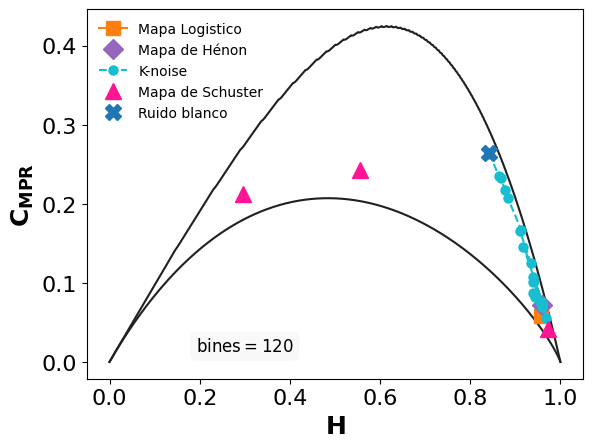

In [24]:
# Cotas
import math
bin = math.factorial(D)
m = 500 #puntos de las cotas
hc_max_curve = maximun_complexityJS_entropy(bin=bin,m=m).T
hc_min_curve = minimum_complexityJS_entropy(bin=bin,m=m).T
hmin, cmin = hc_min_curve
hmax, cmax = hc_max_curve


# Parámetros del mapa logístico
r = 4
# Inicialización
x = np.zeros(100000)
x[0] = 0.1

# Generación de la serie utilizando el mapa logístico
for t in range(1, len(x)):
    x[t] = r * x[t-1] * (1 - x[t-1])

# Calcula mapa_RE (asegúrate de tener definida la función Renyi_entropy_norm)
mapa_RE,mapa_RC =  Complejidad_entropia_JS(calcular_probabilidad(x,bin))

# Function to generate white noise series
def generate_white_noise(length):
    return np.random.randn(length)

# Function to generate regular oscillations
def generate_regular_oscillations(length, frequency, amplitude):
    t = np.linspace(0, 1, length)
    return amplitude * np.sin(2 * np.pi * frequency * t)

# Function to generate Henon map series and average its components
def generate_henon_map_averaged(length, a, b):
    x = np.zeros(length)
    y = np.zeros(length)

    for t in range(1, length):
        x[t] = 1 - a * x[t - 1] ** 2 + y[t - 1]
        y[t] = b * x[t - 1]

    # Average the two components to create a single time series
    averaged_series = (x + y) / 2.0

    return averaged_series

# Número de filas en la matriz
num_filas = 20
alpha_max = 5
paso = alpha_max / num_filas
num_valores = int(alpha_max / paso) + 1  # Número de valores en el vector

# Longitud de cada serie temporal
longitud = 100000

# Opción 1: Distribución logarítmica
alpha_range = np.logspace(0, np.log10(alpha_max), num_valores)

# Matriz para almacenar las series temporales
matriz = np.zeros((num_filas, longitud))
entropy = np.zeros(num_filas)
complexity = np.zeros(num_filas)

k_noise_E = np.zeros(num_filas)
k_noise_C = np.zeros(num_filas)
# Iterar a través de cada fila y generar una serie temporal
for i in range(num_filas):
    # Seleccionar un valor aleatorio de alpha en el rango especificado
    alpha = alpha_range[i]

    # Generar una serie temporal de ruido de color 1/|f|^(alpha)
    serie_temporal = np.real(ifft(fft(np.random.randn(longitud)) * (1 / np.arange(1, longitud + 1) ** (alpha / 2))))

    # Agregar la serie temporal a la matriz
    matriz[i, :] = serie_temporal
    e,c=Complejidad_entropia_JS(calcular_probabilidad(serie_temporal,bin))
    k_noise_E[i] = e
    k_noise_C[i] = c


def schuster_map(x0, z, num_steps):
    """
    Calcula una serie temporal usando el mapa de Schuster.

    Args:
        x0 (float): Valor inicial de x.
        z (float): Parámetro z (debe ser 2, 2.5 o 3).
        num_steps (int): Número de pasos de tiempo para generar la serie temporal.

    Returns:
        List[float]: Lista de valores de la serie temporal generada.
    """
    x_values = []
    x = x0

    for _ in range(num_steps):
        x = (x + x ** z) % 1
        x_values.append(x)

    return x_values

# Generate schuster series
x0 = 0.1  # Valor inicial de x
z_values = [3/2,2,5/2]  # Valores de z
indice=0
schus_E = np.zeros(3)  # Inicializa un ndarray con tres elementos para almacenar valores de e
schus_C = np.zeros(3)  # Inicializa un ndarray con tres elementos para almacenar valores de c

for i in [0,1,2]:
    #print(i)
    serie_temporal = schuster_map(x0, z_values[i], longitud)
    e,c=Complejidad_entropia_JS(calcular_probabilidad(serie_temporal,bin))
    schus_E[i] = e
    schus_C[i] = c

# Generate white noise series
white_noise = generate_white_noise(100000)

# Generate regular oscillations
oscillations = generate_regular_oscillations(100000, frequency=2, amplitude=0.5)

# Generate Henon map series and average its components
henon_map_averaged = generate_henon_map_averaged(100000, a=1.4, b=0.3)

# Calculate Renyi Complexity and Entropy for the new series
white_noise_RE, white_noise_RC = Complejidad_entropia_JS(calcular_probabilidad(white_noise,bin))
oscillations_RE, oscillations_RC = Complejidad_entropia_JS(calcular_probabilidad(oscillations,bin))
henon_map_averaged_RE, henon_map_averaged_RC = Complejidad_entropia_JS(calcular_probabilidad(henon_map_averaged,bin))

# Graficar los diagramas de complejidad y entropía
# Las curvas de hmin y cmin se grafican sin líneas punteadas
plt.plot(mapa_RE, mapa_RC, marker='s', markersize=10, color='tab:orange', label='Mapa Logistico')

# Utiliza líneas punteadas para conectar los puntos de las otras curvas

#plt.plot(oscillations_RE, oscillations_RC, '--o', marker='s', markersize=5, markerfacecolor='b', color='b', label='Regular Oscillations')
plt.plot(henon_map_averaged_RE, henon_map_averaged_RC, 'o', marker='D', markersize=10, color='tab:purple', label='Mapa de Hénon')

plt.plot(k_noise_E, k_noise_C, 'o--', marker='.',  markersize=13,color='tab:cyan', label='K-noise')
plt.plot(schus_E, schus_C, 'o', marker='^', markersize=11, color='deeppink', label='Mapa de Schuster')
plt.plot(white_noise_RE, white_noise_RC, 'o', marker='X', markersize=11, color='tab:blue', label='Ruido blanco')
plt.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{min}$')
plt.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{max}$')

# Leyenda y configuraciones del gráfico
plt.legend(loc='upper left', frameon=False, fontsize=1)
plt.ylabel(r'$\mathbf{C_{MPR}}$', fontsize=18)
plt.xlabel(r'$\mathbf{H}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

text = f'bines$={bin}$'#  and  $D={D}$'
# Crear el gráfico
plt.text(0.3, 0.02, text, fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='whitesmoke', alpha=0.5))

# Configura Matplotlib para que las etiquetas math no estén en cursiva
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.legend(loc='upper left',frameon=False, fontsize=10)

# Aumenta el tamaño de las etiquetas de los ejes (tick labels)
plt.xticks(fontsize=16)  # Cambia el tamaño de las etiquetas del eje X
plt.yticks(fontsize=16)  # Cambia el tamaño de las etiquetas del eje Y

# Crear la cadena de texto con formato para el nombre del archivo
filename = f'/content/complejidadJS.svg'

# Guardar el gráfico con el nombre de archivo actualizado
plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()
